In [1]:
!wget https://www.dropbox.com/s/b1r2vr8rtmv0n77/review.tar.gz -O review.tar.gz 1> downlog_review.txt # this is the bottleneck and enough to track download
!tar -xzf review.tar.gz 2>>downlog_review.txt

!wget https://www.dropbox.com/s/hz9gc4xnyqkn50v/psipred.tar.gz 2>>downlog.txt
!tar -xzf psipred.tar.gz 2>>downlog.txt

--2020-03-29 15:20:59--  https://www.dropbox.com/s/b1r2vr8rtmv0n77/review.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/b1r2vr8rtmv0n77/review.tar.gz [following]
--2020-03-29 15:21:00--  https://www.dropbox.com/s/raw/b1r2vr8rtmv0n77/review.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc05109eda696e79d4c51a56877a.dl.dropboxusercontent.com/cd/0/inline/A010fKrOBOJ97ZGxR3rXvS2RF8d72obnCk6kcopn2kCiQfujYAZmO5BHVzLc6v7BG9iuckHad442F85k2GK3VJ09C7i_dWzoqAyCltxikD77AsPPx4dZviTOrnp8oYEoUU0/file# [following]
--2020-03-29 15:21:00--  https://uc05109eda696e79d4c51a56877a.dl.dropboxusercontent.com/cd/0/inline/A010fKrOBOJ97ZGxR3rXvS2RF8d72obnCk6kcopn2kCiQfujYAZmO5BHVzLc6v7BG9iuckHad442F85k2GK3VJ09C7i_dWzoqAyCltxikD77AsP

In [2]:
# Load libraries, data and pseudorandom nambers for reproducibility
# the number of positive and negatives samples will be displayed
import warnings
warnings.filterwarnings('ignore')
%run scripts/initialize_notebook.py --verbose

import requests

def clean_input(fasta):
    if fasta[0]==">":
        fasta = ''.join(fasta.split('\n')[1:])
    return fasta.replace('\n','').replace('\r','').upper()


def identifier2fasta(sequence):
    page1 = 'https://www.uniprot.org/uniprot/'+ sequence.replace(' ','').replace('\n','') +'.fasta'
    page2 = 'https://www.uniprot.org/uniprot/?query='+ sequence.replace(' ','').replace('\n','') +'&sort=score'

    # case is a uniprot systematic name 
    try:
        page = requests.get(page1).text
    except Exception as e:
        print('fasta page could not be downloaded in the first exception',str(e))
        page = "not found"

    # case is a common name (e.g. gcn4)
    if page[0] == ">":
        return clean_input(page)

    else:
        try:
            page = requests.get(page2).text
            identifier = re.search("<tr id=\".{1,10}\"", page).group()[7:].replace('"','')
            return clean_input(requests.get('https://www.uniprot.org/uniprot/'+ identifier +'.fasta').text)

        except Exception as e:
            print('protein name could not be extracted from uniprot site',str(e))
            identifier2fasta(sequence)
            
    return -1


def structured_regions(protein_id):
    '''
        function retrieves residues that are structured in a protein
        INPUT: protein_id and sequence where id_page is the front page of the uniprot id
        OUTPUT: array with zeros where no structure was found and 1 if structure was found.
    '''
    query_page = 'https://www.uniprot.org/uniprot/?query='+ protein_id.replace(' ','').replace('\n','') +'&sort=score'
    page = requests.get(query_page)

    
    try:
        if page.status_code == 200:
            identifier = protein_id
            id_page = page.text
            
        elif re.search("<title>" + protein_id + " in UniProtKB</title>", page):
            identifier = re.search("<tr id=\".{1,10}\"", page).group()[7:].replace('"','')
            id_page = requests.get('https://www.uniprot.org/uniprot/' + identifier).text
            
        else:
            identifier = protein_id
            id_page = page

        sequence = requests.get(
            'https://www.uniprot.org/uniprot/'+ identifier.replace(' ','').replace('\n','') +'.fasta'
        ).text

    
        sequence = ''.join(sequence.split('\n')[1:])   

    except Exception as e:
        sys.stderr.write(str(e))
        return 

    # output array
    structured_regions = np.zeros(len(sequence), dtype=int)
    
    if re.search("<td>Method</td>", id_page) == None: 
        return structured_regions

    else:   
        try:
            start_section_pdb = re.search("<td>Method</td>", id_page).end()
            end_section_pdb = [i.start() for i in re.finditer(
                                                              "Protein-protein interaction databases", id_page[start_section_pdb:]
                                                             )][-1] + start_section_pdb
        except Exception as e:
            print(e)
            return structured_regions
            
        pdb_raw = id_page[start_section_pdb:end_section_pdb]
        rows = [i for i in pdb_raw.split('<tr>')]

        for i in rows:
            cols = i.split('<td>')
            if len(cols)<6: continue  # header has <6 columns
            if cols[2] == 'X-ray</td>':
                region = np.array((re.search("[0-9]*-[0-9]*", cols[5]).group()).split("-")).astype(int)
                structured_regions[region[0]:region[1]+1] = 1

            
        return structured_regions



def get_score(b_item):
    '''
        function get original adpred score from a heatmap
    '''
    d = {}
    for i in np.sort(np.hstack(b_item)):
        if i in d:
            d[i] = d[i]+1
        else:
            d[i] = 1

    for k,v in d.items():
        if v>=30:
            score = float(k)
    if 'score' not in locals():
        print(d)

    return score

# function to run pripred
from subprocess import Popen, PIPE, call

def psipred(sequence):
    fq = open('borrar.fastq', 'w')
    fq.write(sequence)
    fq.close()

    p = ['bash', 'run_psipred', 'borrar.fastq']
    return Popen(p, stdout=PIPE).communicate()[0].decode('utf-8').strip().replace('C','-')

def make_mutant(wt_sequence, mutations_list):
    mutant = [i for i in wt_sequence]
    
    for mutation in mutations_list:
        wt = mutation[0]
        mut = mutation[-1] 
        pos = int(mutation[1:-1]) -1  # substract 1 since here is 0-based but in publication is 1-based
        
        assert mutant[pos]==wt, "ups... missmatch in protein position..." + mutation
        mutant[pos] = mut
    return ''.join(mutant)

def get_tf(ID):
    sequence = identifier2fasta(ID)
    struct = psipred(sequence)
    ohe = prepare_ohe([sequence, struct])
    adpred = np.array([ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0] for i in range(len(sequence)-30)])
    
    return {'adpred': adpred, 'sequence':sequence}

def get_tf_from_sequence(sequence):
    struct = psipred(sequence)
    ohe = prepare_ohe([sequence, struct])
    adpred = np.array([ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0] for i in range(len(sequence)-30)])
    
    return {'adpred': adpred, 'sequence':sequence}

def get_tf_from_sequence_and_ss(sequence,struct):
    ohe = prepare_ohe([sequence, struct])
    adpred = np.array([ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0] for i in range(len(sequence)-30)])
    
    return {'adpred': adpred, 'sequence':sequence}

# first without structure
def find_AD_lenghts(result,length, smooth=False):
    r=[]
    if smooth:
        result = np.convolve( result, np.ones(12)/12, "same" )
        
    long = 0
    for i in result:
        if i<0.8:
            if long>=length: #5:
                r.append(long)
                long = 0
            else:
                continue
        else:
            long +=1
    return r


def find_AD_positions_considering_structure(adpred, structure, threshold=1):
    r=[]
    
    long = 0
    #for n,i in enumerate(proteome[guessKey[locus]]):  
    for n,i in enumerate(np.convolve( adpred, np.ones(12)/12, "same")):
        try:
            if i<0.8:
                if long>=threshold: #5:
                    r.append(n) #-long//2)
                    long = 0
                else:
                    continue

            elif structure[n]==0:
                long +=1

        except Exception as e:
            print(str(e))
    return r 



def open_fasta(filename):
    adpreds = {}
    with open(filename,'r') as f:
        while True:
            try:
                name, adpred = next(f).strip(), next(f).strip()
                    
                # in case the header did not contain adpred results and the adpred line
                # is the next header
                if adpred == '': continue
                while adpred[0]==">":
                    name = adpred
                    adpred = next(f).strip()

                #name = re.search("[A-Z0-9]*\ ",name)
                name = name.split('|')[1].replace(">","") #.replace("-A","").replace("-B","")
                
                if name == None: 
                    continue
                name = name #.group()

                assert name not in adpreds, "ups... {} repeatedd".format(name)

                adpreds[name] = np.array(adpred.split(',')).astype(float)
            except StopIteration:
                break
    return adpreds        


from scipy.stats import hypergeom
def enrichment(M,n,N, x):
    '''
        Calculates the enrichment of genes in a Pugh group
        
        M = total number of proteins (population size)
        n = group with score>cutoff longer than 5 residues (# of successes in population) 
        N = total of group taken into account (e.g. tf_full) (sample size)
        x = number of successes (withTAD) in that group (drawn successes)
    '''
    if N==0: N=N+0.5
    enriched = (x/N)/(n/M)
    p_val = hypergeom.sf(x-1, M, n, N)
    
    return enriched, p_val

loading data from  /Users/aerijman/Desktop/AD_summary/borrar/ADpred_publication/data/data_complete.db
positives: 36669 samples
negatives: 1016412 samples

    Available methods:
    get_enrichment_scores_table: pandas table with sequences, counts/bin and enrichment scores
    ADPred: Keras model to predict ADs probability in a 30mer.
    Test and Validation sets have 50% positives and 50% negatives.



In [3]:
data_AD = {
    'positives': positives[:,0],
    'negatives': negatives[:,0]
}

with open('/Users/aerijman/Desktop/AD_positives.txt','wb') as f:
    pickle.dump(data_AD, f)

# Figure 2

In [4]:
with open('data/keep_data_figure2.pkl','rb') as f:
    keep_data = pickle.load(f)
    
a0 = keep_data['aa_composition']['a0']
a1 = keep_data['aa_composition']['a1']
b0 = keep_data['aa_composition']['b0']
b1 = keep_data['aa_composition']['b1']

logistic_aa_coef = keep_data['logistic_regression']['coef']

# Dipeptides logistic regresssion 
coefs = keep_data['dipeptides']['coefs']
small_ps = keep_data['dipeptides']['small_ps'] 
ps = keep_data['dipeptides']['ps'] 

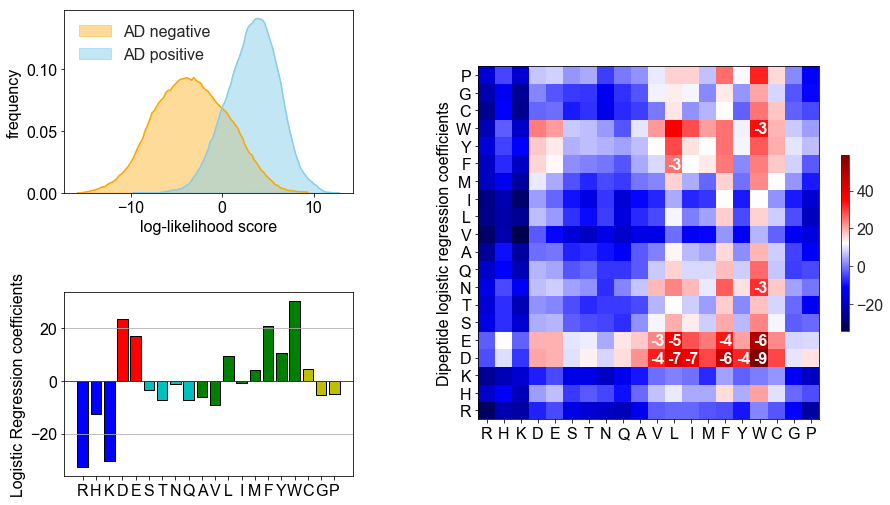

In [5]:
# New layout suggested by Cha`itania

matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(20,20))
grid = plt.GridSpec(20,9, wspace=10, hspace=3)

ax1 = plt.subplot(grid[0:4,0:3]) #, xticklabels={'fontsize':20})
ax2 = plt.subplot(grid[5:9,0:3]) 
ax3 = plt.subplot(grid[1:8,3:7])


# Distribution of aa composition 
sns.set_style('ticks')
ax1.fill(b0,a0, alpha=0.4, c='orange', label='AD negative')
ax1.fill(b1,a1, alpha=0.5, c='skyblue', label='AD positive')

ax1.plot(b0,a0, alpha=1, c='orange')
ax1.plot(b1,a1, alpha=1, c='skyblue')

ax1.set_xlabel('log-likelihood score') #,  fontsize=20)
ax1.set_ylabel('frequency') #, fontsize=20)
ax1.legend(loc=2, frameon=False) #fontsize=20)
ax1.set_ylim(0,)
ax1.locator_params(axis='y', nbins=5)


# Logistic regression aa compossition
cols = ['b']*3+['r']*2+['c']*4+['g']*8+['y']*3
#ax2.bar(np.arange(20), model_single_aa_composition.coef_[0], color=cols, linewidth=1, edgecolor='black')
ax2.bar(np.arange(20), logistic_aa_coef, color=cols, linewidth=1, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.6)

ax2.set_xticks(np.arange(20))
ax2.set_xticklabels(aa) #, fontsize=20)
#ax2.yticks(fontsize=16)
#ax2.set_ylim(-30,30)

ax2.grid(axis='y')
ax2.set_ylabel('Logistic Regression coefficients') #, fontsize=20)
#ax2.tight_layout()

im = ax3.pcolor(coefs.reshape(20,20), cmap='seismic') #jet_r') #Spectral', )
ax3.set_xticks(np.arange(20)+0.5)
ax3.set_yticks(np.arange(20)+0.5)

ax3.set_xticklabels(aa) #, fontsize=20)
ax3.set_yticklabels(aa) #, fontsize=20)

small_ps = np.where(np.array(ps)<0.001)[0]

for i in small_ps:
    ax3.text(i%20+0.1, int(i/20)+0.2, int(np.log10(ps[i])), fontsize=16, color='white', weight='bold')
ax3.set_ylabel('Dipeptide logistic regression coefficients') #, fontsize=20)

from matplotlib import ticker
cb = plt.colorbar(im, shrink=0.5, ax=ax3)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
#cb.ax.tick_params(labelsize=20)

plt.savefig('figure2.png', dpi=600)

# Figure 4B

In [4]:
# pnas 2014 
#GCN4 sequences
name = 'gcn4'
seq = read_fasta('data/' + name + '.fasta')
sstruct = read_horiz('data/' + name + '.horiz')

min_range = 107
max_range = 137
seq = seq[min_range:max_range]
sstruct = sstruct[min_range:max_range]


def predict_seq(ohe_data, ADPred):
    '''
        function outputs probability of TAD for a 30 AA long segment
        INPUT: ohe_data including fasta and ss
        OUTPUT: predictions array (1D) of probabilities over the length of the protein
        NOTE: This functions slides along 30aa long windows and predict the center of the protein.
              The first and last 15 residues are repeated on purpose.
    '''
    # exit if data is not correctly shaped.
    if ohe_data.shape[1] != 23:
        print('shape should be (30,23), wrong amino acid number. Yours is {}'.format(ohe_data.shape[1]))
        return
    if ohe_data.shape[0] != 30:
        print('shape should be (30,23), sequence is not 30 long. Yours is {}'.format(ohe_data.shape[0]))
        return

    seq = ohe_data.reshape(1,30,23,1)
    prediction = ADPred.predict(seq)

    return prediction[0][0]

def predict_single(A, seq, sstruct):
    
    # all selected positions to mutate
    positions = np.arange(0,30)

    # all these combinations get to 20*42=840 single mutants
    
    mutant_info = []
    predictions = []

    # go over each of the positions to be mutated
    for pos in positions:
        residues = {pos:A} #aa}

        # go over each mutant and assume ALL keep the same secondary structure
        for mutant in mutate_protein(seq, residues=residues):

            # keep track of the mutant 
            mutant_info.append([mutant])

            # prepare data for deep model and make prediction
            data = prepare_ohe([mutant,sstruct])
            prediction = predict_seq(data, ADPred)

            # predict TAD over the whole sequence and sum it up
            predictions.append( np.mean(prediction) )

    return predictions, mutant_info

predictions = []
for i in aa:
    pred, _ = predict_single(i, seq, sstruct)
    predictions.append(pred)

predictions = pd.DataFrame(predictions, index=aa, columns=list(seq))

orig_score = predict_seq(prepare_ohe([seq,sstruct]), ADPred)

df = pd.read_csv(analysis_home+'/data/pnas2015.tsv', sep='\t', header=None, index_col=0)
df = df[1]
df.loc['AVWESLFSS']=7.41

heatmap = np.zeros(shape=(20,9))

for i in df.index:
    for n,(j,k) in enumerate(zip(i,'AVWESLFSS')):
        missmatch=0
        if j != k:
            if missmatch==0: missmatch=n
            else: print('not good')
        heatmap[aa.index(j),n] = df.loc[i]

# Johannes and Salma suggested using original values
##heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap)) 
heatmap = pd.DataFrame(heatmap, columns=['A','V','W','E','S','L','F','S','S'], index=aa)
ids = np.hstack([np.arange(51), np.arange(52,180)])

x,y_pnas = np.hstack(predictions.iloc[:,10:19].values)[ids], np.hstack(heatmap.values)[ids]
y_hat_pnas = [np.log(p/(1-p)) for p in x]
slope, intercept, r_value, p_value, std_err = linregress(np.log(y_pnas),y_hat_pnas)


# jackson
gcn4 = identifier2fasta('gcn4')[:101]  # In Jackson et al it's important to test activation of the nAD without the influence of the cAD
mutants = [
    ['M1M'],
    ['F45S'],
    ['G41R','F45L'],
    ['F45Y','D90E'],
    ['S24P','F45I','A80T'],
    ['F48I'],
    ['F48S'],
    ['F48L','Q59R'],
    ['E27K','F48I','E53V'],
    ['V40D','F48I','L84S'],
    ['F48L','V94G','E95N'],
    ['E27K','V29A','F48I'],
    ['T33A','F48S','L65H'],
    ['K37I','Q42K','F67L','A80T'],
    ['T33I','K37R','E52G','S63P','F67S','D68G'],
    ['F69L','L84P','D91G'],
    ['T25A','M39V','P55T','F69S'],
    ['V40A','D66V','F69S','A80V'],
    ['M39K','F69Y','D79N'],
    ['P38S','F69L','P78S','E88K'],
    ['E27V','K37E','I44T','F69S','T76A','L84S'],   # originally was ['E27V','K37E','I45T','F69S','T76A','L84S'], but 44 is I... not 45
    ['K23R','N28T','M39V','D46N','D54G','F69S','A80G','I86T'],
    ['F67A','F69A'],
    ['G41S','F67L','F69L','D79G'],
    ['F97S'],
    ['T25A','F97S'],
    ['N28I','F97S'],
    ['F98S'],
    ['F98V'],
    ['F98 '],  # leave space for the delta in the publication. later clean with str.replace(' ','') 
    ['V94K'],
    ['V40A','I86T'],
    ['D46G','T74K'],
    ['E88K','S99A'],
    ['D46G','D60G','N64S'],
    ['T51P','E53G','D54V'],
    ['N28Y','S34P','Q42H','D54V','Q73R']
]
experimental_scores = [5,0,2,2,2,2,1,3,3,0,1,3,0,3,-1,3,2,0,0,-1,1,1,-1,3,1,1,2,0,4,1,4,2,-1,2,0,3,2]

assert len(experimental_scores) == len(mutants), 'ups...' + str(len(experimental_scores) + str(len(mutants)))

maxs, means = [], []
adpred_profiles = {}
for m in mutants:
    sequence = make_mutant(gcn4, m).replace(' ','')
    struct = psipred(sequence)
    
    ohe = prepare_ohe([sequence, struct])
    adpred = np.array([ADPred.predict(ohe[i:i+30].reshape(1,30,23,1))[0][0] for i in range(len(sequence)-30)])
    
    adpred_profiles[sequence] = adpred
    
    maxs.append(np.max(adpred))
    means.append(np.mean(adpred))
    
    
def normalize(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))
y_jackson = normalize(np.log(means))


# Staller
staller = pd.read_csv('review/Staller.complete.csv', header=None).values  # ADpred scores
Nt = 'QANAATNNNAQNGATQGGTQASQTGAQSSN'
Ct = 'AGSQQQTQGNASSANTSTGTGSTAQSQGSN'

df = pd.read_csv('review/1-s2.csv')
ids = df.replace([np.inf, -np.inf], np.nan).dropna().index  #Lot's of missing values
#df = df.loc[ids]
df.columns

df = df.iloc[:,[0,1,4,5,6,7]]
df = df.loc[ids]
seqs = set(df['ActivationDomainSeq'])

# before collecting Staller indexes, make the adpred matrix correlate with the table. 
# => correlate the indexes by making it a dictionary with same indices=sequences
staller_adpred_dict = {}
for i in df.index:
        staller_adpred_dict[df.loc[i, 'ActivationDomainSeq']] = staller[i,1:]

# lots of repeated sequences in staller's data. Use mean in those.        
df2 = {}
for i in seqs:
    df2[i] = df[df['ActivationDomainSeq']==i][df.columns[2:]].mean(axis=0).values

# make if table again so it's wasy to print
df = pd.DataFrame(df2.values(), index=df2.keys(), columns = df.columns[2:])
df.sample(2)

# staller adpred dict -> only max values --> check that mutations lay on the area meassured !!!
staller_max_dict = {k: np.mean(v) for k,v in staller_adpred_dict.items()}

# make it table and append it to df table
df_adpred = pd.DataFrame(staller_max_dict.values(), index=staller_max_dict.keys())
df_complete = pd.concat([df_adpred, df], axis=1)

# correct column labels
df_complete.columns = ['adpred'] + list(df_complete.columns)[1:]

X = df_complete[['adpred','ActivityAAStarvation_Raw']].values

X = X[~np.isinf(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
assert np.sum((np.isnan(X)) | (np.isinf(X)))==0, "still nans and/or infs in X"

# rescale x to between 0 anad 1
#x = normalize(X[:,0])
x = np.array([ np.log(1/(1-i)) for i in X[:,0] ])
#y = normalize(X[:,1])
y = X[:,1] 

nbins=500
from scipy.stats import kde
k = kde.gaussian_kde(np.vstack([x,y]))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

from sklearn.neighbors import KNeighborsRegressor as kn
nb = kn(n_neighbors=400).fit(x.reshape(-1,1), y)
y_hat = nb.predict(x.reshape(-1,1))
norm = plt.Normalize(np.min(zi), np.max(zi)/2)

Lindas : SpearmanrResult(correlation=0.7721791428834751, pvalue=1.0664530275636027e-36)
[[1.         0.81954044]
 [0.81954044 1.        ]]
staller : SpearmanrResult(correlation=0.5993668536772926, pvalue=3.472758353339306e-257)
[[1.         0.59160722]
 [0.59160722 1.        ]]


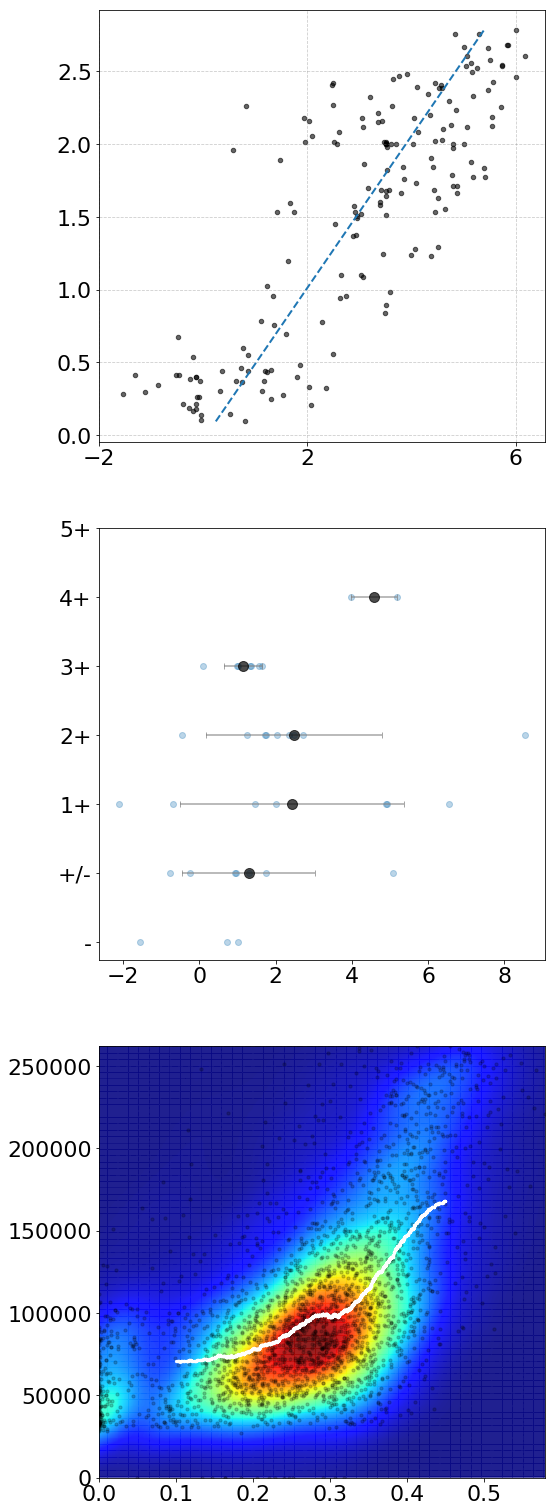

In [5]:
matplotlib.rcParams.update({'font.size': 22})
f,ax = plt.subplots(3,1, figsize=(8,27))

ax[0].scatter(y_hat_pnas, np.log(y_pnas), c='k', alpha=0.6, s=20, marker='o')
ys = [np.min(np.log(y_pnas)), np.max(np.log(y_pnas))]
ax[0].plot([intercept+slope*i for i in ys], ys, ls='--', lw=2)
#ax[0].set_yticks(np.log([0.03,0.1,0.3,1]))
#ax[0].set_yticklabels([0.03,0.1,0.3,1])
ax[0].set_xticks([-2,2,6])
##ax[0].set_ylabel('Warfield et al', fontsize=24)
##ax[0].set_xlabel('- logit(predictions)', fontsize=24)
ax[0].grid(c='grey',ls='--', alpha=0.4)

print('Lindas : {}'.format(spearmanr(y_hat_pnas, np.log(y_pnas))))
print(np.corrcoef(y_hat_pnas, np.log(y_pnas)))

x_jackson = [np.log(p/(1-p)) for p in y_jackson]
#ax[1].scatter(y_jackson, experimental_scores, alpha=0.3)
ax[1].scatter(x_jackson, experimental_scores, alpha=0.3)
#a = np.vstack([experimental_scores, y_jackson]).T
a = np.vstack([experimental_scores, x_jackson]).T
jackson_means = np.array([np.mean(a[np.where(a[:,0]==i)[0],1]) for i in np.unique(a[:,0])])
jackson_stds = np.array([np.std(a[np.where(a[:,0]==i)[0],1]) for i in np.unique(a[:,0])])
ax[1].errorbar(y=np.unique(a[:,0]), x=jackson_means, xerr=jackson_stds, fmt='ok', alpha=0.7, ecolor='grey', capthick=1, capsize=3, markersize=10)
##ax[1].set_xlabel('ADpred score')
##ax[1].set_ylabel('HIS3 expression under histidine starvation conditions')
ax[1].set_yticks(np.arange(-1,6))
ax[1].set_yticklabels(["-", "+/-", "1+","2+","3+","4+","5+"])

# Staller
#ax[2].pcolormesh(xi,yi,zi.reshape(xi.shape), cmap='jet', norm=norm, alpha=0.4)
ax[2].pcolormesh(xi,yi,zi.reshape(xi.shape), cmap='jet', alpha=0.4)
ax[2].scatter(x, y, alpha=0.2, s=10, c='k')
#K = np.where((x>0.18) & (x<0.82))[0]
K = np.where((x>0.1) & (x<0.45))[0]
ax[2].scatter(x[K], y_hat[K], c='white', s=5, alpha=0.9)
#ax[2].set_xlim(0,0.58) #0.9)
#ax[2].set_ylim(0,1)
ax[2].set_xlim(0,0.58) #0.9)
ax[2].set_ylim(0,np.max(y))

print('staller : {}'.format(spearmanr(x,y)))
print(np.corrcoef(x,y))

# Figure 5

In [6]:
experimental = {
    # yeast
    'GAL4_YEAST':  [np.arange(840,881)],
    'GCN4_YEAST':  [np.arange(1,98), np.arange(102,134)],
    'INO2_YEAST':  [np.arange(1,41),np.arange(96,160)],
    'MET4_YEAST':  [np.arange(72,117), np.arange(126,161)],
    'RTG3_YEAST':  [np.arange(1,250), np.arange(375,486)],
    'HAP4_YEAST':  [np.arange(321,490)],
    'RAP1_YEAST':  [np.arange(595,720)],
    
    # human
    'VP16_HHV11':  [np.arange(413,490)], 
    'P53_HUMAN':   [np.arange(1,73)], 
    'MYC_HUMAN':   [np.arange(130,140)], 
    'EPAS1_HUMAN': [np.arange(450,572), np.arange(820,870)], # HIF2A
    'E2F1_HUMAN':  [np.arange(368,437)],
    'MYOD1_HUMAN': [np.arange(3,56)],
    'SMAD4_HUMAN': [np.arange(275,322)], 
    'ETV6_HUMAN':  [], 
    'SP1_HUMAN':   [np.arange(146,251), np.arange(352,494)], 
        
    # fly
    'Q0IGQ2_DROME':[np.arange(50,150)],  # bteb2_DROSOPHILA
    'Q8IQC5_DROME':[np.arange(500,1000)/3],  # mtf1_DROSOPHILA
    'CG14451':     [np.arange(200,275)],  # _DROSOPHILA
    'Q9W4X2_DROME':[np.arange(100,300)]   # HLH3B_DROSOPHILA 
}

names = {
    # yeast
    'GAL4_YEAST':  'Gal4 yeast',
    'GCN4_YEAST':  'Gcn4 yeast',
    'INO2_YEAST':  'Ino2 yeast',
    'MET4_YEAST':  'Met4 yest',
    'RTG3_YEAST':  'Rtg3 yeast',
    'HAP4_YEAST':  'Hap4 yeast',
    'RAP1_YEAST':  'Rap1 yeast',
    
    # human
    'VP16_HHV11':  'VP16',
    'P53_HUMAN':   'P53 human',
    'MYC_HUMAN':   'Myc human',
    'EPAS1_HUMAN': 'Epas1 human',
    'E2F1_HUMAN':  'E2F1 human',
    'MYOD1_HUMAN': 'Myod1 human',
    'SMAD4_HUMAN': 'Smad4 human',
    'ETV6_HUMAN':  'ETV6 human',
    'SP1_HUMAN':   'Sp1 human',
        
    # fly
    'Q0IGQ2_DROME':'bteb2 Drosophila',  # bteb2_DROSOPHILA
    'Q8IQC5_DROME':'Mtf1 drosophila',  # mtf1_DROSOPHILA
    'CG14451':     'CG14451 drosofila',  # _DROSOPHILA
    'Q9W4X2_DROME':'Hlh3b drosophila'   # HLH3B_DROSOPHILA 
}

results = {}

while len(results) < len(experimental):

    for k,v in experimental.items():

        if k in results: 
            continue
        else:
            results[k] = {}
            
        # get adpred from sequence(uniprot) and ss(psipred)
        try:
            tf = get_tf(k)['adpred']
            
        except Exception as e:
            print('in get_tf, and with {}: {}'.format(k,str(e)))

            
        # store data
        results[k]['tf'] = tf
        results[k]['experimental'] = v    

        try:
            results[k]['pdb'] = structured_regions(k)
        except Exception as e:
            del results[k]
            print('in structured_regions, and with {}: {}'.format(k,str(e)))
            

In [7]:
d2p2_pfam_data = {
    # yeast
    'GAL4_YEAST':  [np.arange(9,47), np.arange(20,106), np.arange(244,506)],
    'GCN4_YEAST':  [np.arange(223,280)],
    'INO2_YEAST':  [],
    'MET4_YEAST':  [],
    'RTG3_YEAST':  [np.arange(286,365)],
    'HAP4_YEAST':  [],
    'RAP1_YEAST':  [np.arange(95,213), np.arange(360,439), np.arange(446,594)],
    
    # human
    'VP16_HHV11':  [], 
    'P53_HUMAN':   [np.arange(95,289), np.arange(318,359)], 
    'MYC_HUMAN':   [], 
    'EPAS1_HUMAN': [np.arange(11,72), np.arange(95,201), np.arange(244,346)], # HIF2A
    'E2F1_HUMAN':  [np.arange(127,192), np.arange(202,301)],
    'MYOD1_HUMAN': [np.arange(108,170)],
    'SMAD4_HUMAN': [np.arange(19,137), np.arange(287,544)], 
    'ETV6_HUMAN':  [np.arange(24,122), np.arange(315,439)], 
    'SP1_HUMAN':   [], 
        
    # fly
    'Q0IGQ2_DROME':[np.arange(211,255)],  # bteb2_DROSOPHILA
    'Q8IQC5_DROME':[np.arange(1,66)],  # mtf1_DROSOPHILA
    'CG14451':     [np.arange(74,112)],  # _DROSOPHILA
    'Q9W4X2_DROME':[np.arange(166,233)]   # HLH3B_DROSOPHILA 
}

'''
# In pdb some regions have been resolved wiht X-ray diffraction but are, in reality, disordered 
pdb_exclude = {
    'GAL4_YEAST':  [np.arange(854,874)],
    'EPAS1_HUMAN': [np.arange(523,540)], 
    
}
'''

"\n# In pdb some regions have been resolved wiht X-ray diffraction but are, in reality, disordered \npdb_exclude = {\n    'GAL4_YEAST':  [np.arange(854,874)],\n    'EPAS1_HUMAN': [np.arange(523,540)], \n    \n}\n"

In [8]:
seq = '''MPLNVSFTNRNYDLDYDSVQPYFYCDEEENFYQQQQQSELQPPAPSEDIWKKFELLPTPP
LSPSRRSGLCSPSYVAVTPFSLRGDNDGGGGSFSTADQLEMVTELLGGDMVNQSFICDPD
DETFIKNIIIQDCMWSGFSAAAKLVSEKLASYQAARKDSGSPNPARGHSVCSTSSLYLQD
LSAAASECIDPSVVFPYPLNDSSSPKSCASQDSSAFSPSSDSLLSSTESSPQGSPEPLVL
HEETPPTTSSDSEEEQEDEEEIDVVSVEKRQAPGKRSESGSPSAGGHSKPPHSPLVLKRC
HVSTHQHNYAAPPSTRKDYPAAKRVKLDSVRVLRQISNNRKCTSPRSSDTEENVKRRTHN
VLERQRRNELKRSFFALRDQIPELENNEKAPKVVILKKATAYILSVQAEEQKLISEEDLL
RKRREQLKHKLEQLRNSCA'''.replace('\n','')

ads = np.where(results['MYC_HUMAN']['tf']>=0.5)

B = '\33[41m'
noB ='\33[0m'

sequentia = []
for n, i in enumerate(seq[:-30]):
    if n in ads[0]:
        tmp = B+i+noB
    else:
        tmp = i
    sequentia.append(tmp)

print(''.join(sequentia))

MPLNVSFTNRNYDLDYDSVQPYFYCDEEENFYQQQQQSELQPPAPSEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVTPFSLRGDNDGGGGSFSTADQLEMVTELLGGDMVNQSFICDPDDETFIKNIIIQDCMWSGFSAAAKLVSEKLASYQAARKDSGSPNPARGHSVCSTSSLYLQDLSAAASECIDPSVVFPYPLNDSSSPKSCASQDSSAFSPSSDSLLSSTESSPQGSPEPLVLHEETPPTTSSDSEEEQEDEEEIDVVSVEKRQAPGKRSESGSPSAGGHSKPPHSPLVLKRCHVSTHQHNYAAPPSTRKDYPAAKRVKLDSVRVLRQISNNRKCTSPRSSDTEENVKRRTHNVLERQRRNELKRSFFALRDQIPELENNEKAPKVVILKKATAYILSVQAE


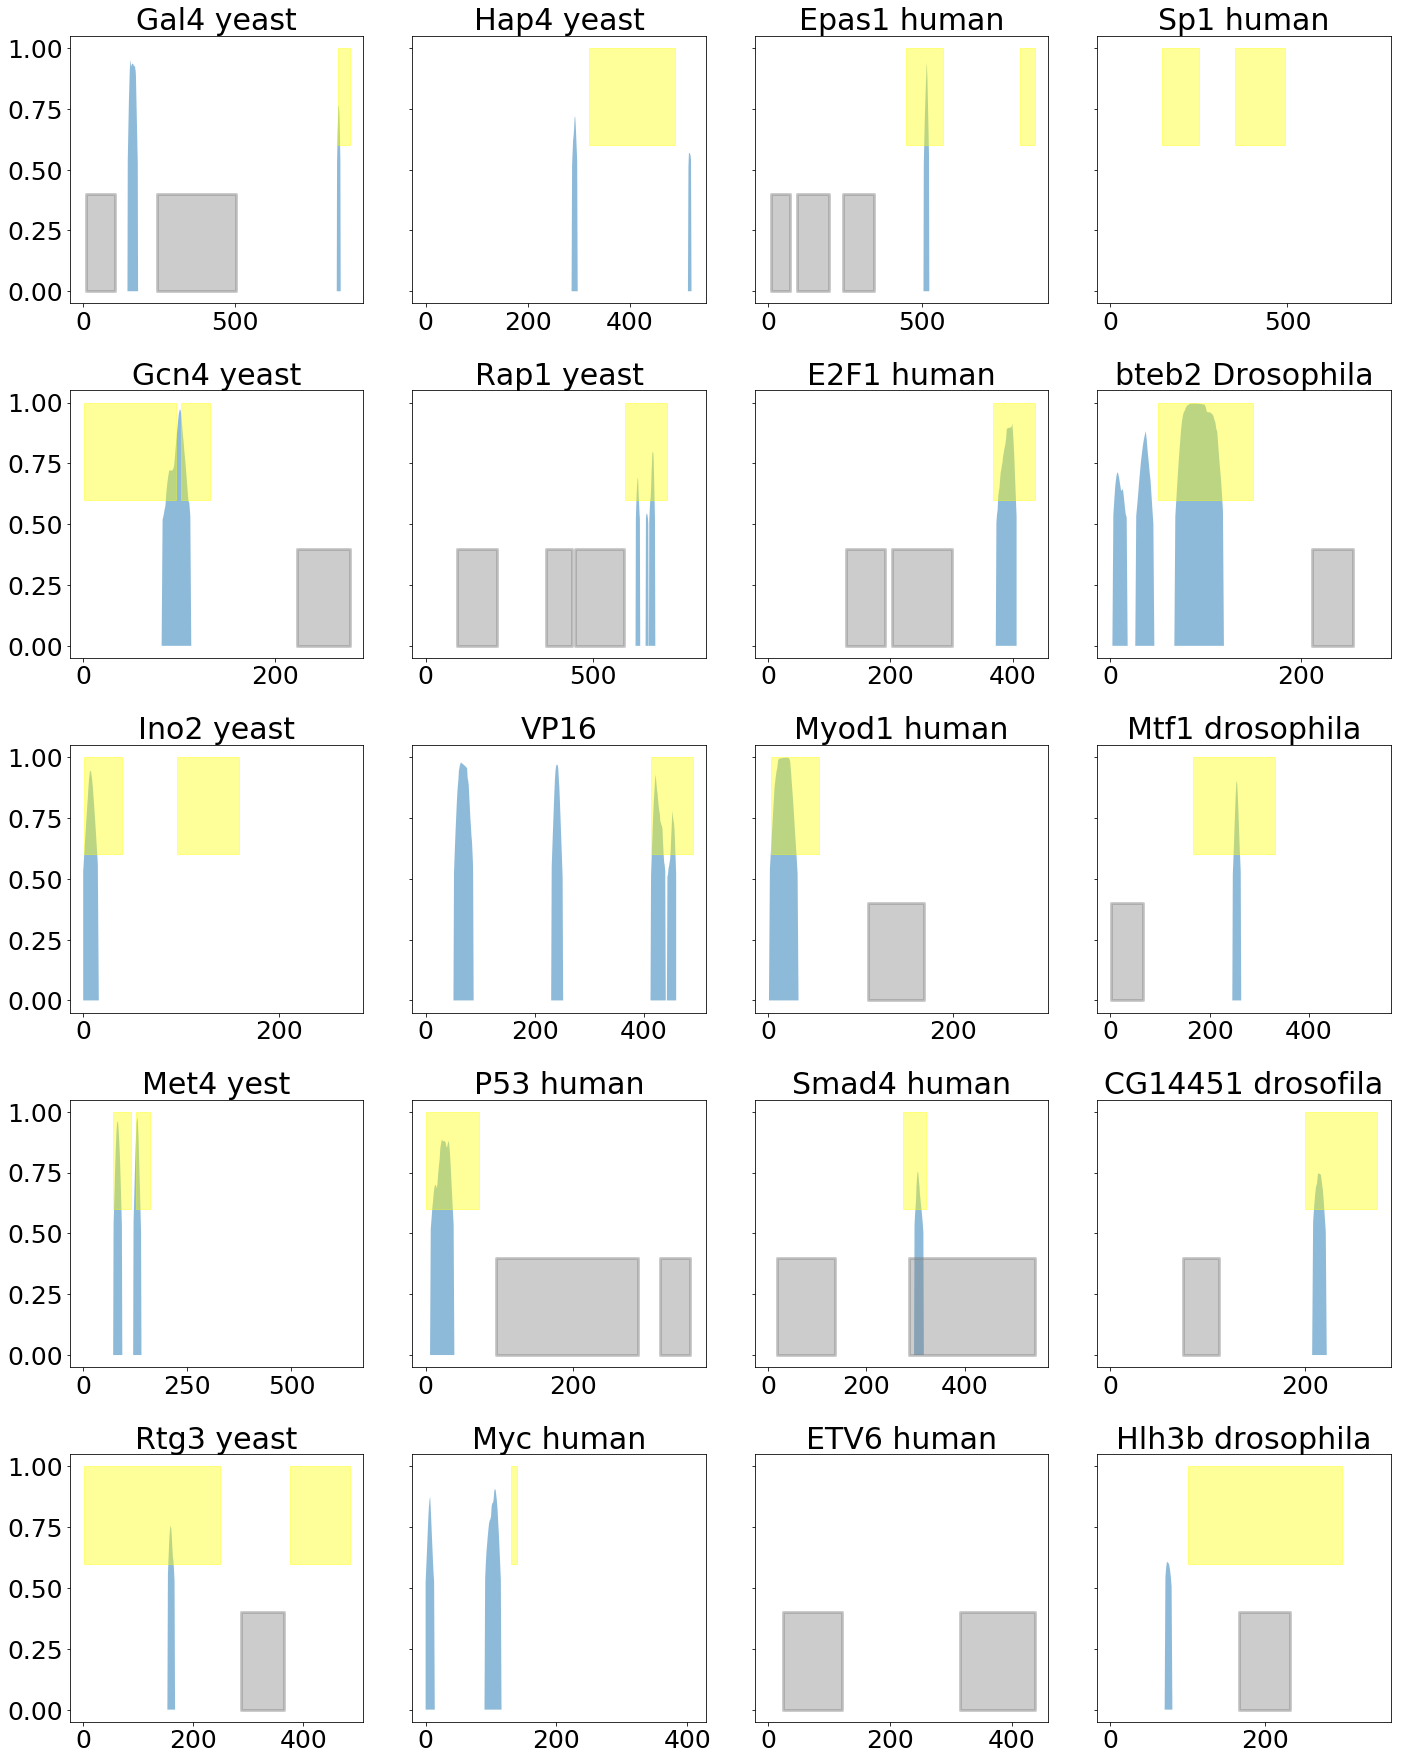

In [9]:
matplotlib.rcParams.update({'font.size': 25})

f,ax = plt.subplots(5,4, figsize=(20,25), sharey=True)

for n1, (k,v) in enumerate(results.items()):
    
    ax1, ax2 = n1%5, n1//5

    # plot adpred
    tf = v['tf']
    
    # denoise and smooth data
    tf = np.convolve(tf, np.ones(15)/15, 'same')
    tf = [i if i>=0.5 else 0 for i in tf]
    
    ax[ax1][ax2].fill_between(np.arange(len(tf)), tf, alpha=0.5)

    # plot experimental validation
    for i in v['experimental']:
        ax[ax1][ax2].fill_between(i, 0.6, 1, color='yellow', alpha=0.4)

    pdb = v['pdb']
    pdb = np.zeros(len(pdb))  # FInally saw that only pfmaA are important!
    
    # add pfam regions to pdb
    if len(p)>0: 
        for p in d2p2_pfam_data[k]:
            pdb[p]=1
    a=0
    for n2,i in enumerate(pdb):
        if i==1 and pdb[n2-1]==0:
            a = n2

        elif ((i==0 and pdb[n2-1]==1) or (n2==len(pdb)-1) and i==1) and a!=0:
            ax[ax1][ax2].fill_between(np.arange(a,n2), 0,0.4, lw=3, color='grey', alpha=0.4)
            a=0
            
    ax[ax1][ax2].set_title(names[k])
    
plt.tight_layout()
plt.savefig('experimentals.png', dpi=500)

# Figure 7

In [10]:
# -----
# HUMAN
# -----
 
h_structures = {}
with open('review/enrichment_humans/structures.human.fasta','r') as f:
    while True:
        try:
            name, struct = next(f).strip()[1:], next(f).strip().split(',')
            assert name not in h_structures, "ups... {} repeated".format(name)
            h_structures[name] = np.array(struct).astype(int)
        except StopIteration:
            break
            
h_adpreds = {}
with open('review/enrichment_humans/uniprot_human_results.adpred.fasta','r') as f:
    while True:
        try:
            name, adpred = next(f).strip(), next(f).strip()
            
            # in case the header did not contain adpred results and the adpred line
            # is the next header
            if adpred == '': continue
            while adpred[0]==">":
                name = adpred
                adpred = next(f).strip()
            
            name = re.search("\|.*\|",name)
            if name == None: 
                continue
            name = name.group().replace("|",'')
            adpred = adpred.split(',')
            
            assert name not in h_adpreds, "ups... {} repeatedd".format(name)
            
            h_adpreds[name] = np.array(adpred).astype(float)
        except StopIteration:
            break


#ids = set(h_adpreds.keys()).intersection(set(h_structures.keys()))
#h_adpreds = {i:j for i,j in h_adpreds.items() if i in ids}
            
with open('review/enrichment_humans/hTFs_reviewed-ONLY.masked_isoforms.uniprot','r') as f:
    h_TFs = {i.strip() for i in f}.intersection(set(h_adpreds.keys()))
    
thresholds = np.arange(70) #[5,10,15,20,25]  # [10,20,30,40,50]
TOTALs = {i:0 for i in thresholds}
    
for threshold in thresholds:
    for k,v in h_adpreds.items():
        TOTALs[threshold] += len(find_AD_lenghts(v, threshold)) > 0 
        #TOTALs[threshold] += len(find_AD_positions_considering_structure(v, h_structures[k], threshold))
        
TFs = {i:0 for i in thresholds}        

for threshold in thresholds:
    for k in h_TFs:
        TFs[threshold] += len(find_AD_lenghts(h_adpreds[k], threshold)) > 0 
        #TFs[threshold] += len(find_AD_positions_considering_structure(h_adpreds[k], h_structures[k], threshold))
enrich_human, pval_human = [],[]
for i in thresholds:
    ep = enrichment(len(h_adpreds), TOTALs[i], len(h_TFs), TFs[i])
    enrich_human.append(ep[0])
    pval_human.append(ep[1])       

In [11]:
# ---
# FLY
# ---
Dir = 'review/enrichment_fly/'


stampfel = {}
predicts = []

with open('review/Stumpfel_adpred.results.fasta','r') as f:
    while True:
        try:
            line = next(f).strip()
            if line[0]==">":
                if predicts != []:
                    stampfel[name] = predicts
                name = line[1:]
                predicts = []
            else:
                try:
                    predicts = np.array(line.split(',')).astype(float)
                except Exception:
                    print(name)
                    name=[]
                    predicts = []
        except StopIteration:
            break
            
            
            
Dir = 'review/enrichment_fly/'
f_adpreds = {}

with open(Dir + 'fly.adpred.results.uniprot','r') as f:
    while True:
        try:
            name, adpred = next(f).strip(), next(f).strip()
            
            # in case the header did not contain adpred results and the adpred line
            # is the next header
            if adpred == '': continue
            while adpred[0]==">":
                name = adpred
                adpred = next(f).strip()
                
                if len(adpred) == 0:
                    adpred = [">"]
            
            name = re.search("\|.*\|",name)
            if name == None: 
                continue
            name = name.group().replace("|",'')
            adpred = adpred.split(',')
            
            #assert name not in h_adpreds, "ups... {} repeatedd".format(name)
            
            f_adpreds[name] = np.array(adpred).astype(float)
        except StopIteration:
            break      
        
with open(Dir + 'all','r') as f:
    f_proteome = {i.strip() for i in f}

#with open(Dir + 'tfs','r') as f:
#    f_TFs = {i.strip() for i in f}
 
f_TFs = set(stampfel.keys())

fly2uniprot = {}
with open(Dir + 'all_dict.tsv','r') as f:
    while True:
        try:
            line=next(f).strip().split('\t')
            fly2uniprot[line[0]] = line[1]
            
        except StopIteration:
            break
            
            
def find_AD_positions_considering_structure(uniprot_id, threshold=1):
    r=[]
    
    long = 0
    #for n,i in enumerate(proteome[guessKey[locus]]):  
    for n,i in enumerate(np.convolve( f_adpreds[uniprot_id], np.ones(12)/12, "same")):
        try:
            if i<0.8:
                if long>=threshold: #5:
                    r.append(n) #-long//2)
                    long = 0
                else:
                    continue

            else:
                long+=1
                #try:  # if n is larger than structures or doesn't exists...
                #    if h_structures[uniprot_id][n]==0:
                #        long+=1
                #except Exception:
                #     long+=1
                

        except Exception as e:
            print(str(e))
    return r 



with open(Dir + 'filtered_flybase.ids','r') as f:
    Filter = [fly2uniprot[i.strip()] for i in f if i.strip() in fly2uniprot.keys()]

Filtered = [k for k in fly2uniprot.values() if k not in Filter]

TFs = {fly2uniprot[i] for i in f_TFs if i in fly2uniprot}.intersection(set(f_adpreds.keys()))
Proteome = {fly2uniprot[i] for i in f_proteome if i in fly2uniprot}.intersection(set(f_adpreds.keys()))

             
thresholds = np.arange(70) #[5,10,20,30,40,50]
TOTALs = {i:0 for i in thresholds}
TF = {i:0 for i in thresholds}
enrich_fly, pval_fly = [],[]
for threshold in thresholds:
    for k in Proteome:
        #is_ad = len(find_AD_positions_considering_structure(k, threshold)) > 0
        is_ad = len(find_AD_lenghts(f_adpreds[k], threshold, smooth=False)) > 0
        
        TOTALs[threshold] += is_ad
        if k in TFs:
            TF[threshold] += is_ad

    ep = enrichment(len(Proteome), #len(f_adpreds), 
                    TOTALs[threshold],
                    len(TFs),
                    TF[threshold]
                   )
    enrich_fly.append(ep[0])
    pval_fly.append(ep[1])
    
    
'''fly_enrichments = []
for i in thresholds:
    fly_enrichments.append(
        enrichment(
        len(f_adpreds),
        TOTALs[i],
        len(TFs),
        TF[i]
    ))
    #print(TOTALs[i]/len(f_adpreds), TF[i]/len(TFs))
    
fly_enrichments'''

FBgn0050420
FBgn0003715
FBgn0053936
FBgn0014467
FBgn0262707
FBgn0013948
FBgn0028420
FBgn0032904
FBgn0033310
FBgn0259172
FBgn0015014
FBgn0263350
FBgn0263347
FBgn0086697
FBgn0029704
FBgn0000258
FBgn0023444
FBgn0003600
FBgn0008654
FBgn0259719
FBgn0027936


'fly_enrichments = []\nfor i in thresholds:\n    fly_enrichments.append(\n        enrichment(\n        len(f_adpreds),\n        TOTALs[i],\n        len(TFs),\n        TF[i]\n    ))\n    #print(TOTALs[i]/len(f_adpreds), TF[i]/len(TFs))\n    \nfly_enrichments'

In [12]:
# -----
# YEAST
# -----
# forgot to add the confidence of secondary_structure_oredictions...
path = analysis_home + '/data/secondary_structure/'
tmp, tnp = [], []
for f in [i for i in os.listdir(path) if i[-11:]==".output.csv"]:
    predsName = f + ".predictions.npz"

    df = pd.read_csv(path + f, index_col=0)
    tmp.append(df[['sequence','secondStruct','disorder']])
    nf = np.load(path + predsName, allow_pickle=True)
    tnp.append(nf[nf.files[0]])

predictions = np.hstack(tnp)
df = pd.concat(tmp)

# finally join all fields into a single data structure to facilitate further analysis
df['predictions'] = predictions

# Apparently what I needed here are the disorder probabilities rather than yes/no
Dir = analysis_home+'/data/disorder_yeast/'
files = [i for i in os.listdir(Dir) if re.search(".results$",i)]

disorders = {}
for i in files:
    d = read_iupred_results(Dir+i)
    disorders.update(d)

df2 = pd.DataFrame([disorders]).T
idx = df2.index.intersection(df.index)
df2 = df2.loc[idx]

df = pd.concat([df.loc[idx],df2], axis=1)
df.columns = ['sequence', 'secondStruct', 'disorder', 'predictions', 'iupred']

del(df2)





# include disorder in df
fixed_disorder = []
for n,i in enumerate(df.iupred.values):
    i = [t for t in i if t!=""]
    fixed_disorder.append(np.array(i).astype(float))
    
df.iupred = fixed_disorder





# include probability of a-helix in df
helicity  = {}
helicity2 = {}

#for i in files:
d, d2  = read_psipred_results(analysis_home + '/data/secondary_structure/total.results') #+i)

for i in d2.keys():
    if re.search(",", i):
        print('oh oh!!!')

helicity.update(d)
helicity2.update(d2)


# joined datasets
df2 = pd.DataFrame([helicity2]).T
idx = df2.index.intersection(df.index)
df2 = df2.loc[idx]

df = pd.concat([df.loc[idx],df2], axis=1)
df.columns = ['sequence', 'secondStruct', 'disorder', 'predictions', 'iupred', 'helicity_proba']

del(df2)

                                        ## SGD ##
# collect data from SGD 
SGD = pd.read_csv('https://downloads.yeastgenome.org/curation/chromosomal_feature/SGD_features.tab', index_col=3, sep='\t', header=None)
SGD = SGD[SGD[1]=='ORF'][4]

                                        ## TF ##
# Steve's list of TFs
# long list including potential NON-TF
tf_full = pd.read_csv(analysis_home + '/data/TFs.csv')
tf_full = tf_full['Systematic name'].values

# short list excluding potential False TF
tf_short = pd.read_csv(analysis_home + '/data/TFs_small.csv')
tf_short = tf_short['Systematic name'].values

                                        ## Nuclear ##
# Are tf enriched in the Nucleus?
localization = pd.read_csv(analysis_home + '/data/proteome_localization.csv', index_col=0)
X = localization.iloc[:,1] 
nuclear = [i for i in set(X) if re.search("nucl",i)]
X = pd.DataFrame([1 if i in nuclear else 0 for i in X], index=localization.index, columns=['loc'])
nuclear = X[X['loc']==1].index


total_idx = df.index.intersection(X.index)
nuclear_idx = nuclear.intersection(total_idx)
tf_full_idx = set(tf_full).intersection(total_idx)
tf_short_idx = set(tf_short).intersection(total_idx)

print('{} in tf_full\n{} in tf_short\n{} in total\n{} in nuclear\n'.format(
    len(tf_full_idx), len(tf_short_idx), len(total_idx), len(nuclear_idx)))


# set cutoff to predict TADs in the proteome
cutoff=0.8 

results = np.zeros(shape=(df.shape[0],4))
for n,prot in enumerate(df.predictions):
    results[n] = predict_motif_statistics(prot, cutoff)
    
results = pd.DataFrame(results, index=df.index, columns = ['length', 'start_position', 'gral_mean', 'mean_longest_region'])


M = len(total_idx)
n = len(tf_full_idx)
N = len(nuclear_idx)
x = len(nuclear_idx.intersection(tf_full_idx))
e,p = enrichment(M,n,N,x)
print(M,n,N,x,e,p)


enrich_yeast, pval_yeast = [],[]

for l in range(70):
    withTADs = results[results.length>=l].index
    nuclear_TADs = withTADs.intersection(nuclear_idx)
    
    M = len(results.index)
    n = len(withTADs) 
    N = len(tf_short_idx) #.intersection(nuclear_idx))
    x = len(tf_short_idx.intersection(withTADs)) 

    e,p = enrichment(M,n,N,x)
    enrich_yeast.append(e)
    pval_yeast.append(p)

175 in tf_full
132 in tf_short
4802 in total
812 in nuclear

4802 175 812 81 2.737241379310345 2.4750143024221987e-20


In [13]:
# tf_yeas, h_TFs, TFs
lTFs = list(TFs)
lh_TFs = list(h_TFs)
tableS3 = ['human,drosophila,yeast']
for n in range(len(lh_TFs)):
    y, f, h = '', '',''
    if n<len(tf_yeast): 
        y = tf_yeast[n]

    if n<len(lTFs):
        f = lTFs[n]
    
    h = lh_TFs[n]
    tableS3.append(','.join([h,f,y]))

with open('tableS3.csv','w') as f:
    f.write('\n'.join(tableS3))

NameError: name 'tf_yeast' is not defined

[0.0881943100864587, 0.0058264059960918884, 0.009095746428758988, 0.5660728723137158, 0.6406829420197659, 0.9624947519082555]
[0.6835000832948425, 0.6880448525325582, 0.8025503743486722, 0.9130860540392092, 0.9757852556525645, 0.9912481237618571]


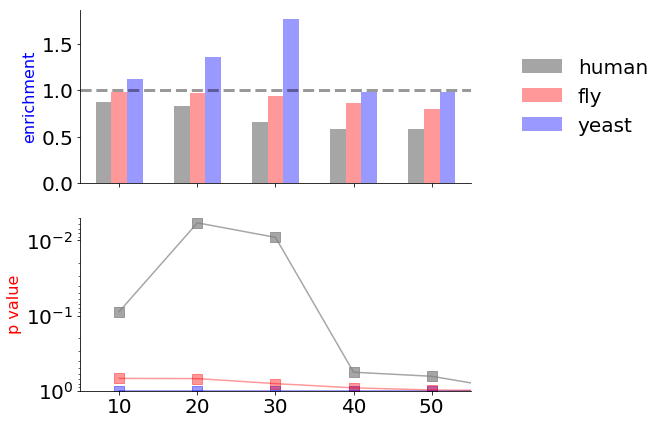

In [15]:
### Will try to break the axis

enrich2 = np.convolve(enrich_human, np.ones(4)/4, 'same')
pval2 = np.convolve(pval_human, np.ones(4)/4,'same')   
ys_human = [np.mean(enrich2[i:i+10]) for i in np.arange(5, len(enrich2)-10, 10)]
ys2_human = [np.mean(pval2[i:i+10]) for i in np.arange(5, len(pval2)-10, 10)]

enrich2 = np.convolve(enrich_fly, np.ones(4)/4, 'same')
pval2 = np.convolve(pval_fly, np.ones(4)/4,'same')   
ys_fly = [np.mean(enrich2[i:i+10]) for i in np.arange(5, len(enrich2)-10, 10)]
ys2_fly = [np.mean(pval2[i:i+10]) for i in np.arange(5, len(pval2)-10, 10)]

enrich2 = np.convolve(enrich_yeast, np.ones(4)/4, 'same')
pval2 = np.convolve(pval_yeast, np.ones(4)/4,'same')   
ys_yeast = [np.mean(enrich2[i:i+10]) for i in np.arange(5, len(enrich2)-10, 10)]
ys2_yeast = [np.mean(pval2[i:i+10]) for i in np.arange(5, len(pval2)-10, 10)]


matplotlib.rcParams.update({'font.size': 20})
f,(ax1,ax2) = plt.subplots(2, sharex=True, figsize=(7,7))

ax1.bar(np.arange(len(ys_human))-0.2, ys_human, width=0.2, alpha=0.7, color='gray', label='human')
ax1.bar(np.arange(len(ys_fly)), ys_fly, width=0.2, alpha=0.4, color='r', label='fly')
ax1.bar(np.arange(len(ys_yeast))+0.2, ys_yeast, width=0.2, alpha=0.4, color='b', label='yeast')

ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(np.arange(10,70,10))
ax1.set_ylabel('enrichment', color='b', fontsize=16)
ax1.plot(np.arange(6)-0.5, [1]*6, ls='--', alpha=0.4, color='k', lw=3)
ax1.set_xlim(-0.5,4.5)

ax2.scatter(np.arange(len(ys2_human)), ys2_human, alpha=0.4, color='b', s=100, marker='s')
ax2.plot(np.arange(len(ys2_human)), ys2_human, alpha=0.4, color='b')
ax2.scatter(np.arange(len(ys2_fly)), ys2_fly, alpha=0.4, color='r', s=100, marker='s')
ax2.plot(np.arange(len(ys2_fly)), ys2_fly, alpha=0.4, color='r')
ax2.scatter(np.arange(len(ys2_yeast)), ys2_yeast, alpha=0.7, color='gray', s=100, marker='s')
ax2.plot(np.arange(len(ys2_yeast)), ys2_yeast, alpha=0.7, color='gray')

ax1.legend(loc="center right", bbox_to_anchor=(1.5,0.5), frameon=False)

ax2.set_ylabel('p value', color='r', fontsize=16)
ax2.set_yscale('log')

ax2.set_ylim((0.005,1)[::-1])
#ax2.set_ylim((10e-36,1)[::-1])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

#for n in [0,1,2,3,4]:
#    ax2.text(n, 10e-8, '{:.3f}'.format(ys2_human[n]), color='gray', alpha=0.7)
#    ax2.text(n, 10e-17, '{:.3f}'.format(ys2_yeast[n]), color='b', alpha=0.4)
print(ys2_yeast)
print(ys2_fly)

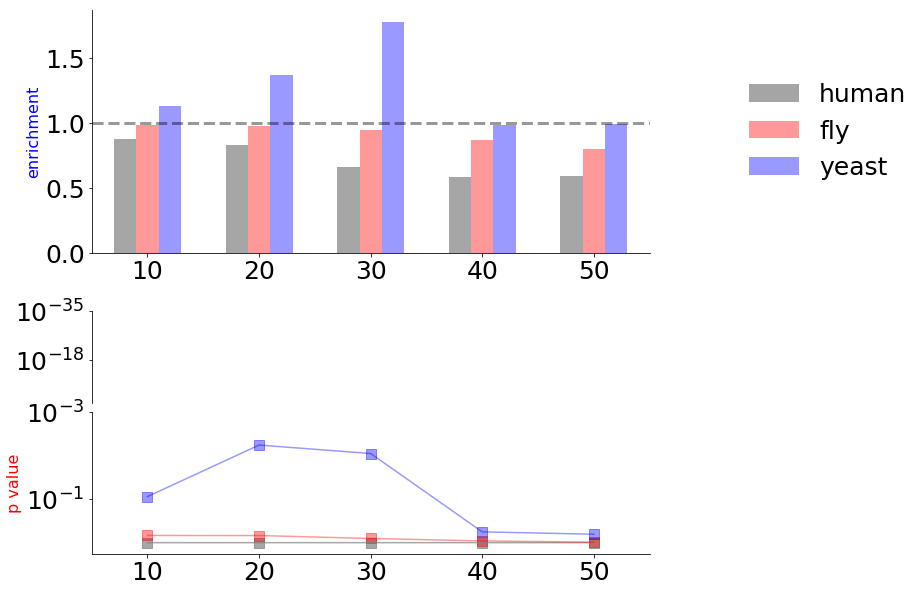

In [16]:
enrich2 = np.convolve(enrich_human, np.ones(4)/4, 'same')
pval2 = np.convolve(pval_human, np.ones(4)/4,'same')   
ys_human = [np.mean(enrich2[i:i+10]) for i in np.arange(5, len(enrich2)-10, 10)]
ys2_human = [np.mean(pval2[i:i+10]) for i in np.arange(5, len(pval2)-10, 10)]

enrich2 = np.convolve(enrich_fly, np.ones(4)/4, 'same')
pval2 = np.convolve(pval_fly, np.ones(4)/4,'same')   
ys_fly = [np.mean(enrich2[i:i+10]) for i in np.arange(5, len(enrich2)-10, 10)]
ys2_fly = [np.mean(pval2[i:i+10]) for i in np.arange(5, len(pval2)-10, 10)]

enrich2 = np.convolve(enrich_yeast, np.ones(4)/4, 'same')
pval2 = np.convolve(pval_yeast, np.ones(4)/4,'same')   
ys_yeast = [np.mean(enrich2[i:i+10]) for i in np.arange(5, len(enrich2)-10, 10)]
ys2_yeast = [np.mean(pval2[i:i+10]) for i in np.arange(5, len(pval2)-10, 10)]


matplotlib.rcParams.update({'font.size': 25})
#f,(ax1,ax2) = plt.subplots(2, sharex=True, figsize=(7,7))

plt.figure(figsize=(10,10))
grid = plt.GridSpec(11,15, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0:5,0:15])
ax2 = plt.subplot(grid[6:8,:])
ax3 = plt.subplot(grid[8:11,:])

ax1.bar(np.arange(len(ys_human))-0.2, ys_human, width=0.2, alpha=0.7, color='gray', label='human')
ax1.bar(np.arange(len(ys_fly)), ys_fly, width=0.2, alpha=0.4, color='r', label='fly')
ax1.bar(np.arange(len(ys_yeast))+0.2, ys_yeast, width=0.2, alpha=0.4, color='b', label='yeast')

ax3.set_xlim(-0.5, 4.5)
ax3.set_xticks(np.arange(5))
ax3.set_xticklabels(np.arange(10,60,10))

ax2.set_xlim(-0.5, 4.5)
ax2.set_xticks(np.arange(5))
ax2.set_xticklabels(np.arange(10,60,10))

ax1.set_ylabel('enrichment', color='b', fontsize=16)
ax1.plot(np.arange(6)-0.5, [1]*6, ls='--', alpha=0.4, color='k', lw=3)
ax1.set_xlim(-0.5,4.5)
ax1.set_xticks(np.arange(5))
ax1.set_xticklabels(np.arange(10,60,10))


ax2.scatter(np.arange(4), ys2_fly[:4], alpha=0.4, color='r', s=100, marker='s')
ax2.plot(np.arange(4), ys2_fly[:4], alpha=0.4, color='r')

ax3.scatter(np.arange(len(ys2_human)), ys2_human, alpha=0.7, color='gray', s=100, marker='s')
ax3.plot(np.arange(5), ys2_human[:5], alpha=0.7, color='gray')
ax3.scatter(np.arange(len(ys2_fly)), ys2_fly, alpha=0.4, color='r', s=100, marker='s')
ax3.plot(np.arange(5), ys2_fly[:5], alpha=0.4, color='r')
ax3.scatter(np.arange(len(ys2_yeast)), ys2_yeast, alpha=0.4, color='b', s=100, marker='s')
ax3.plot(np.arange(5), ys2_yeast[:5], alpha=0.4, color='b')

ax1.legend(loc="center right", bbox_to_anchor=(1.5,0.5), frameon=False)

ax3.set_ylabel('p value', color='r', fontsize=16)
ax3.set_yscale('log')
ax2.set_yscale('log')

ax3.set_ylim((0.001,1.8)[::-1])
ax2.set_ylim((10e-36,0.001)[::-1])
#ax2.set_ylim((10e-36,1)[::-1])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_xticks([])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

#for n in [0,1,2,3,4]:
#    ax2.text(n, 10e-8, '{:.3f}'.format(ys2_human[n]), color='gray', alpha=0.7)
#    ax2.text(n, 10e-17, '{:.3f}'.format(ys2_yeast[n]), color='b', alpha=0.4)

# Figure S1

In [17]:
# in this cell I define freqs,                 aa freqs merged library
#                       proteome_freq          aa freqs proteome
#                       arg3_1_freq            aa freqs library O1
#                       arg3_2_freq            aa freqs library O2


# frequenciess of positives and negatives that make the whole dataset
all_sequences = np.hstack([positives[:,0],negatives[:,0]])
freqs = np.mean(np.hstack(get_aa_frequencies(all_sequences)).T, axis=0)


# frequencies of yeast proteome
proteome = []
tmp=[]
with open('data/orf_trans_all.fasta', 'r') as f:
    while True:
        try:
            line = next(f)
            if line[0]==">":
                if 'tmp' in locals():
                    proteome.append(''.join(tmp).replace('*',''))
                tmp = []
            else:
                tmp.append(line.strip())
        except StopIteration:
            break
            
proteome_freq = np.mean(np.hstack( get_aa_frequencies(proteome[1:])).T, axis=0)


with open('review/ARG_O1.df.pkl', 'rb') as f:
    arg3_1 = pickle.load(f)
    
with open('review/ARG_O2.df.pkl', 'rb') as f:
    arg3_2 = pickle.load(f)    
  

arg3_1_freq = np.mean(np.hstack( get_aa_frequencies(list(arg3_1.index))).T, axis=0)
arg3_2_freq = np.mean(np.hstack( get_aa_frequencies(list(arg3_2.index))).T, axis=0)

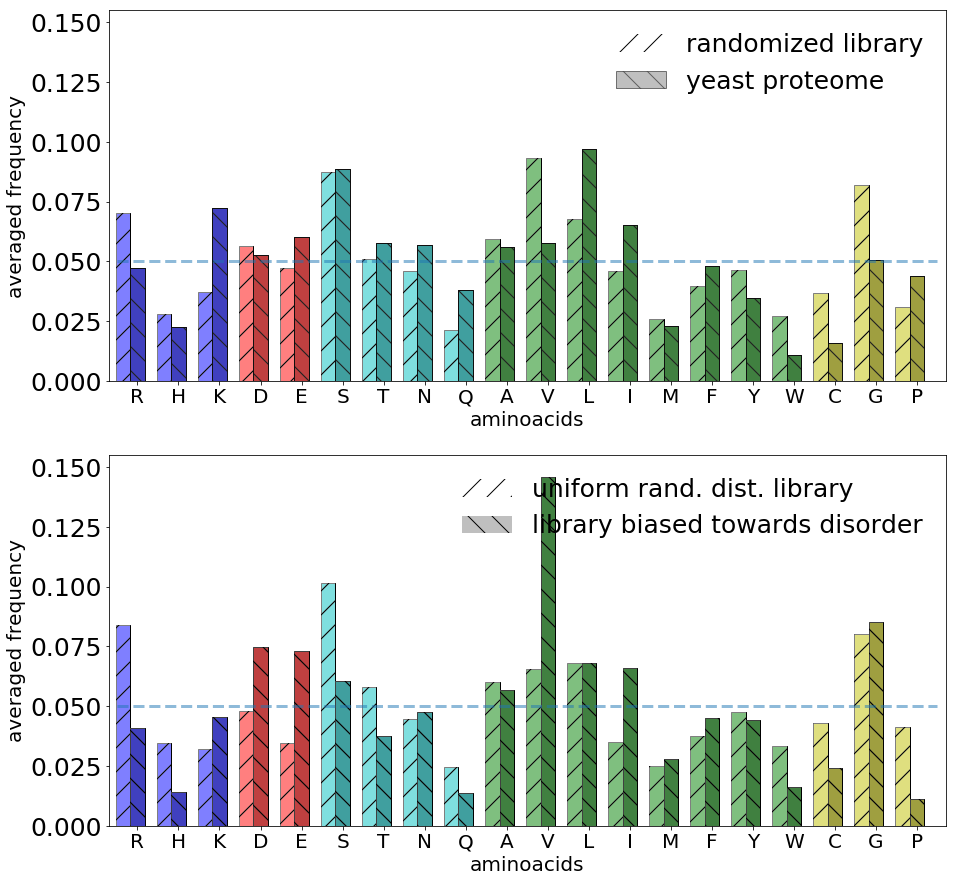

In [18]:
f, (ax1,ax2) = plt.subplots(2,1, figsize=(15,15))

patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
# plt.bar(x,y,..., edgecolor='black', hatch=patterns[i]

# ax1.bar(np.arange(len(ys_human))-0.2, ys_human, width=0.2, alpha=0.4, color='b', label='human')

cols = ['b']*3 + ['r']*2 + ['c']*4 + ['g']*8 + ['y']*3
x = np.arange(len(aa))
ax1.bar(x-0.35, freqs, width=0.35, color=cols, hatch=patterns[0], edgecolor='k')
ax1.bar(x-0.35, freqs, width=0.35, color='white', hatch=patterns[0], label='randomized library', alpha=0.5)

ax1.bar(x, proteome_freq, width=0.35, color=cols, hatch=patterns[1], edgecolor='k')
ax1.bar(x, proteome_freq, width=0.35, color='grey', hatch=patterns[1], edgecolor='k', label='yeast proteome', alpha=0.5)

ax2.bar(x-0.35, arg3_1_freq, width=0.35, color=cols, hatch=patterns[0], edgecolor='k')
ax2.bar(x-0.35, arg3_1_freq, width=0.35, color='white', hatch=patterns[0], alpha=0.5, label='uniform rand. dist. library')
ax2.bar(x, arg3_2_freq, width=0.35, color=cols, hatch=patterns[1], edgecolor='k')
ax2.bar(x, arg3_2_freq, width=0.35, color="grey", hatch=patterns[1], alpha=0.5, label='library biased towards disorder')



for i in [ax1,ax2]:
    i.set_xticks(np.arange(len(aa)))
    i.set_xticklabels(aa, fontsize=20)
    i.set_xlabel('aminoacids', fontsize=20)
    i.set_ylabel('averaged frequency', fontsize=20)
    i.plot([-0.5,19.5],[0.05, 0.05], ls='--', alpha=0.5, lw=3)
    i.set_xlim(-0.7,19.7)
    i.legend(frameon=False) #, loc="upper right")
    i.set_ylim(0,0.155)